Timings:

Hardware           | Backend | Time / Epoch
:------------------|:--------|------------:
 CPU               | TF      | 3 hrs
 Titan X (maxwell) | TF      | 4 min
 Titan X (maxwell) | TH      | 7 min

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sunxin/minico

1.13.2
2.2.4


Using TensorFlow backend.


In [2]:
import numpy as np
from collections import defaultdict
from keras.datasets import mnist
from keras import models
from keras import layers
from keras import optimizers
from keras.utils.generic_utils import Progbar
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
np.random.seed(1337)
num_classes = 10

In [4]:
def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 28, 28, 1)
    cnn = models.Sequential()

    cnn.add(layers.Dense(3 * 3 * 384, input_dim=latent_size, activation='relu'))
    cnn.add(layers.Reshape((3, 3, 384)))

    # upsample to (7, 7, ...)
    cnn.add(layers.Conv2DTranspose(192, 5, strides=1, padding='valid',
                                   activation='relu',
                                   kernel_initializer='glorot_normal'))
    cnn.add(layers.BatchNormalization())

    # upsample to (14, 14, ...)
    cnn.add(layers.Conv2DTranspose(96, 5, strides=2, padding='same',
                                   activation='relu',
                                   kernel_initializer='glorot_normal'))
    cnn.add(layers.BatchNormalization())

    # upsample to (28, 28, ...)
    cnn.add(layers.Conv2DTranspose(1, 5, strides=2, padding='same',
                                   activation='tanh',
                                   kernel_initializer='glorot_normal'))

    # this is the z space commonly referred to in GAN papers
    latent = layers.Input(shape=(latent_size, ))

    # this will be our label
    image_class = layers.Input(shape=(1,), dtype='int32')

    cls = layers.Embedding(num_classes, latent_size,
                           embeddings_initializer='glorot_normal')(image_class)

    # hadamard product between z-space and a class conditional embedding
    h = layers.multiply([latent, cls])

    fake_image = cnn(h)

    return models.Model([latent, image_class], fake_image)

In [5]:
def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = models.Sequential()

    cnn.add(layers.Conv2D(32, 3, padding='same', strides=2,
                          input_shape=(28, 28, 1)))
    cnn.add(layers.LeakyReLU(0.2))
    cnn.add(layers.Dropout(0.3))

    cnn.add(layers.Conv2D(64, 3, padding='same', strides=1))
    cnn.add(layers.LeakyReLU(0.2))
    cnn.add(layers.Dropout(0.3))

    cnn.add(layers.Conv2D(128, 3, padding='same', strides=2))
    cnn.add(layers.LeakyReLU(0.2))
    cnn.add(layers.Dropout(0.3))

    cnn.add(layers.Conv2D(256, 3, padding='same', strides=1))
    cnn.add(layers.LeakyReLU(0.2))
    cnn.add(layers.Dropout(0.3))

    cnn.add(layers.Flatten())

    image = layers.Input(shape=(28, 28, 1))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = layers.Dense(1, activation='sigmoid', name='generation')(features)
    aux = layers.Dense(num_classes, activation='softmax', name='auxiliary')(features)

    return models.Model(image, [fake, aux])

In [6]:
# batch and latent size taken from the paper
epochs = 20
batch_size = 100
latent_size = 100

# Adam parameters suggested in https://arxiv.org/abs/1511.06434
adam_lr = 0.0002
adam_beta_1 = 0.5

In [7]:
# build the discriminator
print('Discriminator model:')
discriminator = build_discriminator()
discriminator.compile(
    optimizer=optimizers.Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)
discriminator.summary()

Discriminator model:
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 12544)        387840      input_1[0][0]                    
__________________________________________________________________________________________________
generation (Dense)              (None, 1)            12545       sequential_1[1][0]               
__________________________________________________________________________________________________


In [8]:
# build the generator
generator = build_generator(latent_size)

latent = layers.Input(shape=(latent_size, ))
image_class = layers.Input(shape=(1,), dtype='int32')

# get a fake image
fake = generator([latent, image_class])

# we only want to be able to train generation for the combined model
discriminator.trainable = False
fake, aux = discriminator(fake)
combined = models.Model([latent, image_class], [fake, aux])

print('Combined model:')
combined.compile(
    optimizer=optimizers.Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)
combined.summary()

Combined model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 28, 28, 1)    2657897     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 1), (None, 1 525835      model_2[1][0]               

In [9]:
# get our mnist data, and force it to be of shape (..., 28, 28, 1) with
# range [-1, 1]
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

x_test = (x_test.astype(np.float32) - 127.5) / 127.5
x_test = np.expand_dims(x_test, axis=-1)

num_train, num_test = x_train.shape[0], x_test.shape[0]

train_history = defaultdict(list)
test_history = defaultdict(list)

In [10]:
for epoch in range(1, epochs + 1):
    print('Epoch {}/{}'.format(epoch, epochs))

    num_batches = int(np.ceil(x_train.shape[0] / batch_size))
    progress_bar = Progbar(target=num_batches)

    epoch_gen_loss = []
    epoch_disc_loss = []

    for index in range(num_batches):
        # get a batch of real images
        image_batch = x_train[index * batch_size:(index + 1) * batch_size]
        label_batch = y_train[index * batch_size:(index + 1) * batch_size]

        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (len(image_batch), latent_size))

        # sample some labels from p_c
        sampled_labels = np.random.randint(0, num_classes, len(image_batch))

        # generate a batch of fake images, using the generated labels as a
        # conditioner. We reshape the sampled labels to be
        # (len(image_batch), 1) so that we can feed them into the embedding
        # layer as a length one sequence
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=0)

        x = np.concatenate((image_batch, generated_images))

        # use one-sided soft real/fake labels
        # Salimans et al., 2016
        # https://arxiv.org/pdf/1606.03498.pdf (Section 3.4)
        soft_zero, soft_one = 0, 0.95
        y = np.array(
            [soft_one] * len(image_batch) + [soft_zero] * len(image_batch))
        aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

        # we don't want the discriminator to also maximize the classification
        # accuracy of the auxiliary classifier on generated images, so we
        # don't train discriminator to produce class labels for generated
        # images (see https://openreview.net/forum?id=rJXTf9Bxg).
        # To preserve sum of sample weights for the auxiliary classifier,
        # we assign sample weight of 2 to the real images.
        disc_sample_weight = [np.ones(2 * len(image_batch)),
                              np.concatenate((np.ones(len(image_batch)) * 2,
                                              np.zeros(len(image_batch))))]

        # see if the discriminator can figure itself out...
        epoch_disc_loss.append(discriminator.train_on_batch(
            x, [y, aux_y], sample_weight=disc_sample_weight))

        # make new noise. we generate 2 * batch size here such that we have
        # the generator optimize over an identical number of images as the
        # discriminator
        noise = np.random.uniform(-1, 1, (2 * len(image_batch), latent_size))
        sampled_labels = np.random.randint(0, num_classes, 2 * len(image_batch))

        # we want to train the generator to trick the discriminator
        # For the generator, we want all the {fake, not-fake} labels to say
        # not-fake
        trick = np.ones(2 * len(image_batch)) * soft_one

        epoch_gen_loss.append(combined.train_on_batch(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels]))

        progress_bar.update(index + 1)

    print('Testing for epoch {}:'.format(epoch))

    # evaluate the testing loss here

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (num_test, latent_size))

    # sample some labels from p_c and generate images from them
    sampled_labels = np.random.randint(0, num_classes, num_test)
    generated_images = generator.predict(
        [noise, sampled_labels.reshape((-1, 1))], verbose=False)

    x = np.concatenate((x_test, generated_images))
    y = np.array([1] * num_test + [0] * num_test)
    aux_y = np.concatenate((y_test, sampled_labels), axis=0)

    # see if the discriminator can figure itself out...
    discriminator_test_loss = discriminator.evaluate(
        x, [y, aux_y], verbose=False)

    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

    # make new noise
    noise = np.random.uniform(-1, 1, (2 * num_test, latent_size))
    sampled_labels = np.random.randint(0, num_classes, 2 * num_test)

    trick = np.ones(2 * num_test)

    generator_test_loss = combined.evaluate(
        [noise, sampled_labels.reshape((-1, 1))],
        [trick, sampled_labels], verbose=False)

    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

    # generate an epoch report on performance
    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)

    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)

    print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
        'component', *discriminator.metrics_names))
    print('-' * 65)

    ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.4f} | {3:<5.4f}'
    print(ROW_FMT.format('generator (train)',
                         *train_history['generator'][-1]))
    print(ROW_FMT.format('generator (test)',
                         *test_history['generator'][-1]))
    print(ROW_FMT.format('discriminator (train)',
                         *train_history['discriminator'][-1]))
    print(ROW_FMT.format('discriminator (test)',
                         *test_history['discriminator'][-1]))

    # save weights every epoch
    generator.save_weights(
        'params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
    discriminator.save_weights(
        'params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)

    # generate some digits to display
    num_rows = 40
    noise = np.tile(np.random.uniform(-1, 1, (num_rows, latent_size)),
                    (num_classes, 1))

    sampled_labels = np.array([
        [i] * num_rows for i in range(num_classes)
    ]).reshape(-1, 1)

    # get a batch to display
    generated_images = generator.predict(
        [noise, sampled_labels], verbose=0)

    # prepare real images sorted by class label
    real_labels = y_train[(epoch - 1) * num_rows * num_classes:
                          epoch * num_rows * num_classes]
    indices = np.argsort(real_labels, axis=0)
    real_images = x_train[(epoch - 1) * num_rows * num_classes:
                          epoch * num_rows * num_classes][indices]

    # display generated images, white separator, real images
    img = np.concatenate(
        (generated_images,
         np.repeat(np.ones_like(x_train[:1]), num_rows, axis=0),
         real_images))

    # arrange them into a grid
    img = (np.concatenate([r.reshape(-1, 28)
                           for r in np.split(img, 2 * num_classes + 1)
                           ], axis=-1) * 127.5 + 127.5).astype(np.uint8)

    Image.fromarray(img).save(
        'plot_epoch_{0:03d}_generated.png'.format(epoch))

Epoch 1/20
Instructions for updating:
Use tf.cast instead.


/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


600/600 [==============================] - 31s 51ms/step
Testing for epoch 1:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.51 | 1.0538          | 0.4593
generator (test)       | 0.79 | 0.7283          | 0.0581
discriminator (train)  | 1.52 | 0.6701          | 0.8501
discriminator (test)   | 0.87 | 0.7535          | 0.1137
Epoch 2/20
600/600 [==============================] - 27s 45ms/step
Testing for epoch 2:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 0.93 | 0.9004          | 0.0248
generator (test)       | 0.71 | 0.7036          | 0.0085
discriminator (train)  | 1.00 | 0.6936          | 0.3062
discriminator (test)   | 0.74 | 0.6900          | 0.0483
Epoch 3/20
600/600 [==============================] - 27s 45ms/step
Testing for epoch 3:
component              | l

600/600 [==============================] - 28s 46ms/step
Testing for epoch 20:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 0.77 | 0.7703          | 0.0022
generator (test)       | 0.80 | 0.7953          | 0.0005
discriminator (train)  | 0.75 | 0.6984          | 0.0512
discriminator (test)   | 0.76 | 0.7467          | 0.0113


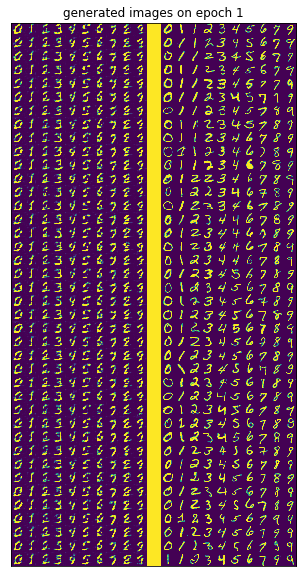

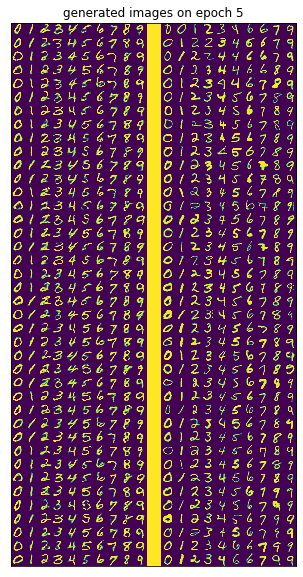

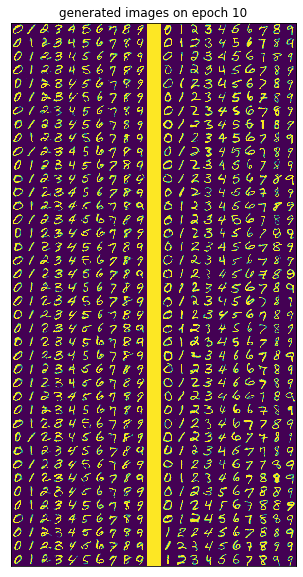

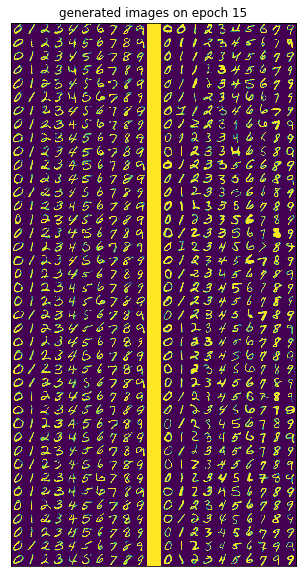

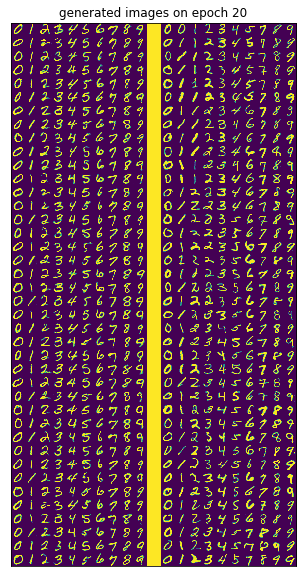

In [11]:
for epoch in [1, 5, 10, 15, 20]:
    img = mpimg.imread('plot_epoch_{:03d}_generated.png'.format(epoch))
    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title("generated images on epoch {}".format(epoch))
    plt.show()